# Notebook for Setting Up, Training, and Visualization of MultiVI‑Splice (MuData Version)

This notebook assumes that a combined MuData object has already been created (using your other notebook).
It will:
1. Load the combined MuData (made by `ann_data_maker.ipynb`).
2. Set up MultiVI‑Splice with the MuData object.
3. Train the model (with optional W&B logging).
4. Save (and optionally reload) the model.
5. Retrieve imputed splicing and expression estimates.
6. Visualize the latent representation via UMAP.
7. Optionally write out the updated MuData object.

## 0. Configure Paths

In [9]:
MUDATA_PATH = "/gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/MOUSE_SPLICING_FOUNDATION/MODEL_INPUT/052025/mouse_foundation_data_20250502_155802_ge_splice_combined.h5mu"
MODEL_SAVE_DIR = "/gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/models"
IMPUTED_DFS_PATH = "/gpfs/commons/home/svaidyanathan/dfs/imputed_dfs.h5"
OUTPUT_UPDATED_MUDATA = "/gpfs/commons/groups/knowles_lab/Karin/TMS_MODELING/DATA_FILES/BRAIN_ONLY/02112025/MULTVI_TMS_BRAINONLY_MUDATA_GE_ATSE.h5mu"

print("MuData path:", MUDATA_PATH)
print("Model save directory:", MODEL_SAVE_DIR)
print("Imputed DataFrames path:", IMPUTED_DFS_PATH)
print("Output updated MuData path:", OUTPUT_UPDATED_MUDATA)

MuData path: /gpfs/commons/groups/knowles_lab/Karin/Leaflet-analysis-WD/MOUSE_SPLICING_FOUNDATION/MODEL_INPUT/052025/mouse_foundation_data_20250502_155802_ge_splice_combined.h5mu
Model save directory: /gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/models
Imputed DataFrames path: /gpfs/commons/home/svaidyanathan/dfs/imputed_dfs.h5
Output updated MuData path: /gpfs/commons/groups/knowles_lab/Karin/TMS_MODELING/DATA_FILES/BRAIN_ONLY/02112025/MULTVI_TMS_BRAINONLY_MUDATA_GE_ATSE.h5mu


## 1. Imports

In [2]:
import scvi  # your local copy of scvi-tools

print("scvi version:", getattr(scvi, "__version__", "No version attr"))
print("scvi loaded from:", scvi.__file__)

import anndata as ad
import mudata as mu
import pandas as pd
import numpy as np
import scanpy as sc
import scipy.sparse as sp
import wandb
from pytorch_lightning.loggers import WandbLogger
import matplotlib.pyplot as plt

scvi version: 1.3.1
scvi loaded from: /gpfs/commons/home/svaidyanathan/repos/scvi-tools-splicing/src/scvi/__init__.py


## 2. Initialize W&B Logger (Optional)Loading in our stacked annData (created using the ann_data_maker notebook).

In [3]:
wandb_logger = WandbLogger(project="multivi-splice")  

## 3. Load  MuData

We assume this MuData has all necessary fields.

In [5]:
mdata = mu.read_h5mu(MUDATA_PATH)
print("MuData modalities loaded:", list(mdata.mod.keys()))
print(mdata)

/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/mudata/_core/mudata.py:1531: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
  self._update_attr("var", axis=0, join_common=join_common)
/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/mudata/_core/mudata.py:931: UserWarning: Cannot join columns with the same name because var_names are intersecting.
  warnings.warn(
/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/mudata/_core/mudata.py:1429: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will 

MuData modalities loaded: ['rna', 'splicing']
MuData object with n_obs × n_vars = 157418 × 53867
  obs:	'cell_id', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'tissue', 'dataset', 'broad_cell_type', 'cell_id_index', 'cell_name', 'modality'
  obsm:	'X_library_size'
  2 modalities
    rna:	157418 x 19022
      obs:	'cell_id_index', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'subtissue', 'tissue', 'dataset', 'cell_name', 'cell_id', 'broad_cell_type', 'seqtech', 'cell_clean', 'modality'
      var:	'ID', 'modality'
      obsm:	'X_library_size'
      layers:	'length_norm', 'log_norm', 'predicted_log_norm_tms', 'raw_counts'
    splicing:	157418 x 34845
      obs:	'cell_id_index', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'subtissue', 'tissue', 'dataset', 'cell_name', 'cell_id', 'broad_cell_type', 'seqtech', 'cell_clean', 'modality'
      var:	'ID', 'modality'
      layers:	'cell_by_cluster_matrix', 'cell_by_junction_matrix', 'junc_ratio'


## 3. Set Up MultiVI‑Splice Model Using the MuData Object

Use `setup_mudata` to register modalities. Here, adjust the keys to match those in your MuData.

For this example, we assume:
- The GE AnnData (for gene expression) is under modality key `"rna"` with its raw counts in `"raw_counts"`.
- The ATSE AnnData (for splicing) is used for raw junction counts and the two additional splicing layers.
  

In [6]:
scvi.model.MULTIVISPLICE.setup_mudata(
    mdata,
    batch_key="mouse.id",
    categorical_covariate_keys = ["dataset"],
    size_factor_key = "X_library_size",
    rna_layer="raw_counts",
    junc_ratio_layer="junc_ratio",
    atse_counts_layer="cell_by_cluster_matrix",
    junc_counts_layer="cell_by_junction_matrix",
    modalities={"rna_layer": "rna", "junc_ratio_layer": "splicing"},
)

model = scvi.model.MULTIVISPLICE(
    mdata,
    n_genes=(mdata["rna"].var["modality"] == "Gene_Expression").sum(),
    n_junctions=(mdata["splicing"].var["modality"] == "Splicing").sum(),
)
model.view_anndata_setup()

INFO     Generating sequential column names                                                                        


/gpfs/commons/home/svaidyanathan/repos/scvi-tools-splicing/src/scvi/data/fields/_dataframe_field.py:187: UserWarning: Category 129 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  categorical_mapping = _make_column_categorical(
/gpfs/commons/home/svaidyanathan/repos/scvi-tools-splicing/src/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[junc_ratio] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


Anndata setup with scvi-tools version 1.3.1.

Setup via `MULTIVISPLICE.setup_anndata` with arguments:

{
│   'rna_layer': 'raw_counts',
│   'junc_ratio_layer': 'junc_ratio',
│   'atse_counts_layer': 'cell_by_cluster_matrix',
│   'junc_counts_layer': 'cell_by_junction_matrix',
│   'batch_key': 'mouse.id',
│   'size_factor_key': 'X_library_size',
│   'categorical_covariate_keys': ['dataset'],
│   'continuous_covariate_keys': None,
│   'idx_layer': None,
│   'modalities': {'rna_layer': 'rna', 'junc_ratio_layer': 'splicing'}
}

         Summary Statistics          
┏━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━┓
┃     Summary Stat Key     ┃ Value  ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━┩
│    n_atse_counts_key     │ 34845  │
│         n_batch          │  543   │
│         n_cells          │ 157418 │
│ n_extra_categorical_covs │   1    │
│ n_extra_continuous_covs  │   0    │
│    n_junc_counts_key     │ 34845  │
│       n_junc_ratio       │ 34845  │
│         n_labels         │   1    │
│      n_size_factor       │   1    │
│          n_vars          │ 19022  │
└──────────────────────────┴────────┘

                                   Data Registry                                    
┏━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Registry Key      ┃                   scvi-tools Location                   ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│           X            │          adata.mod['rna'].layers['raw_counts']          │
│    atse_counts_key     │ adata.mod['splicing'].layers['cell_by_cluster_matrix']  │
│         batch          │                adata.obs['_scvi_batch']                 │
│ extra_categorical_covs │       adata.obsm['_scvi_extra_categorical_covs']        │
│         ind_x          │                  adata.obs['_indices']                  │
│    junc_counts_key     │ adata.mod['splicing'].layers['cell_by_junction_matrix'] │
│       junc_ratio       │       adata.mod['splicing'].layers['junc_ratio']        │
│         labels         │                adata.obs['_scvi_labels']                │
│      size_factor       │              adata.obsm['X_library_size']               │
└────────────────────────┴─────────────────────────────────────────────────────────┘

                     batch State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃    Source Location    ┃  Categories   ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['mouse.id'] │     3_8_M     │          0          │
│                       │     3_9_M     │          1          │
│                       │    3_10_M     │          2          │
│                       │ 3_10_M/3_11_M │          3          │
│                       │    3_11_M     │          4          │
│                       │    3_38_F     │          5          │
│                       │ 3_38_F/3_39_F │          6          │
│                       │    3_39_F     │          7          │
│                       │    3_56_F     │          8          │
│                       │    3_57_F     │          9          │
│                       │    18_45_M    │         10          │
│                       │    18_46_F    │         11          │
│                       │    18_47_F    │         12          │
│                       │    18_53_M    │         13          │
│                       │    24_58_M    │         14          │
│                       │    24_59_M    │         15          │
│                       │    24_60_M    │         16          │
│                       │    24_61_M    │         17          │
│                       │    184750     │         18          │
│                       │    184752     │         19          │
│                       │    184756     │         20          │
│                       │    185199     │         21          │
│                       │    185200     │         22          │
│                       │    222454     │         23          │
│                       │    223184     │         24          │
│                       │    225675     │         25          │
│                       │    225974     │         26          │
│                       │    226022     │         27          │
│                       │    226054     │         28          │
│                       │    226056     │         29          │
│                       │    226423     │         30          │
│                       │    226961     │         31          │
│                       │    227236     │         32          │
│                       │    227800     │         33          │
│                       │    227802     │         34          │
│                       │    227804     │         35          │
│                       │    228567     │         36          │
│                       │    228568     │         37          │
│                       │    228844     │         38          │
│                       │    228855     │         39          │
│                       │    228861     │         40          │
│                       │    228862     │         41          │
│                       │    229243     │         42          │
│                       │    229643     │         43          │
│                       │    229645     │         44          │
│                       │    229734     │         45          │
│                       │    230635     │         46          │
│                       │    230645     │         47          │
│                       │    231322     │         48          │
│                       │    231501     │         49          │
│                       │    232036     │         50          │
│                       │    232190     │         51          │
│                       │    232344     │         52          │
│                       │    232345     │         53          │
│                       │    233175     │         54          │
│                       │    233280     │         55          │
│                       │    233508     │         56          │
│                       │    233509     │         57          │
│                       │    233

                     labels State Registry                      
┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃      Source Location      ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['_scvi_labels'] │     0      │          0          │
└───────────────────────────┴────────────┴─────────────────────┘

           extra_categorical_covs State Registry           
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━┓
┃   Source Location    ┃ Categories ┃ scvi-tools Encoding ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━┩
│ adata.obs['dataset'] │     AB     │          0          │
│                      │    TMS     │          1          │
│                      │            │                     │
└──────────────────────┴────────────┴─────────────────────┘

## 5. Train Model (with W&B Logging) and Save

If you don't want to log to W&B, remove `logger=wandb_logger`.

In [ ]:
model.train(logger=wandb_logger)

model.save(MODEL_SAVE_DIR, overwrite=True)
print(f"Model saved to: {MODEL_SAVE_DIR}")

/scratch/ipykernel_2125016/1115290015.py:1: DeprecationWarning: `save_best` is deprecated in v1.2 and will be removed in v1.3. Please use `enable_checkpointing` instead. See https://github.com/scverse/scvi-tools/issues/2568 for more details.
  model.train(logger=wandb_logger)
/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /gpfs/commons/home/svaidyanathan/miniconda3/envs/scv ...
GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/gpfs/commons/home/svaidyanathan/miniconda3/envs/scvi-env/lib/python3.12/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run 

Training:   0%|          | 0/500 [00:00<?, ?it/s]

## 6. (Optional) Reload Model

Reload the trained model from disk if you want to use it in a new session.

In [10]:
#mdata = mu.read_h5mu(MUDATA_PATH)
model = scvi.model.MULTIVISPLICE.load(MODEL_SAVE_DIR, adata=mdata)
print("Model reloaded. Current AnnData shape:", mdata.shape)

Trainer will use only 1 of 3 GPUs because it is running inside an interactive / notebook environment. You may try to set `Trainer(devices=3)` but please note that multi-GPU inside interactive / notebook environments is considered experimental and unstable. Your mileage may vary.


INFO     File /gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/models/model.pt already downloaded     


/gpfs/commons/home/svaidyanathan/repos/scvi-tools-splicing/src/scvi/data/fields/_dataframe_field.py:227: UserWarning: Category 129 in adata.obs['_scvi_batch'] has fewer than 3 cells. Models may not train properly.
  new_mapping = _make_column_categorical(
/gpfs/commons/home/svaidyanathan/repos/scvi-tools-splicing/src/scvi/data/fields/_base_field.py:63: UserWarning: adata.layers[junc_ratio] does not contain unnormalized count data. Are you sure this is what you want?
  self.validate_field(adata)


Model reloaded. Current AnnData shape: (157418, 53867)


## 7. Retrieve Imputed Splicing/Expression

- `get_splicing_estimates()` returns imputed splicing usage ratios.
- `get_normalized_expression()` returns normalized gene expression.
- We store them in an HDF5 file for further analysis.

In [9]:

imputed_splicing_estimates = model.get_splicing_estimates()
imputed_splicing_estimates.to_hdf(IMPUTED_DFS_PATH, key="imputed_splicing_estimates", mode="w")
imputed_splicing_estimates = None

imputed_expression_estimates = model.get_normalized_expression()
imputed_expression_estimates.to_hdf(IMPUTED_DFS_PATH, key="imputed_expression_estimates", mode="a")
imputed_expression_estimates = None

print(f"Imputed splicing and expression DataFrames stored in {IMPUTED_DFS_PATH}")

AttributeError: 'MULTIVISPLICE' object has no attribute 'get_splicing_estimates'

## 8. Visualize Latent Representation (UMAP)

1. Add the model's latent representation to `.obsm`.
2. Calculate neighbors/UMAP.
3. Plot with different color labels.

Getting the latent representation and adding it as an obsm field called "X_multivi"

In [11]:
print("Computing latent representation and UMAP...")
latent_key = "X_multivi"
mdata["rna"].obsm[latent_key] = model.get_latent_representation()

sc.pp.neighbors(mdata["rna"], use_rep=latent_key)
sc.tl.umap(mdata["rna"], min_dist=0.2)
print("UMAP complete.")

Computing latent representation and UMAP...
UMAP complete.


In [22]:
group = "broad_cell_type"
groups = ['cell_id', 'age', 'cell_ontology_class', 'mouse.id', 'sex', 'tissue', 'dataset', 'broad_cell_type', 'cell_id_index', 'cell_name', 'modality']

for g in groups:
    print(f'___________________________{g}___________________________\n')
    print(f'{mdata.obs[g]})')

___________________________cell_id___________________________

0               A10_B000120
1               A10_B000126
2               A10_B000127
3               A10_B000166
4               A10_B000169
                ...        
157413    US-1250275_E2_S86
157414    US-1250275_E2_S87
157415    US-1250275_E2_S88
157416    US-1250275_E2_S89
157417    US-1250275_E2_S90
Name: cell_id, Length: 157418, dtype: object)
___________________________age___________________________

0         18m
1          3m
2          3m
3          3m
4         18m
         ... 
157413     2m
157414     2m
157415     2m
157416     2m
157417     2m
Name: age, Length: 157418, dtype: category
Categories (4, object): ['2m', '3m', '18m', '24m'])
___________________________cell_ontology_class___________________________

0         basal epithelial cell of tracheobronchial tree
1                                     bulge keratinocyte
2                                           myeloid cell
3                            

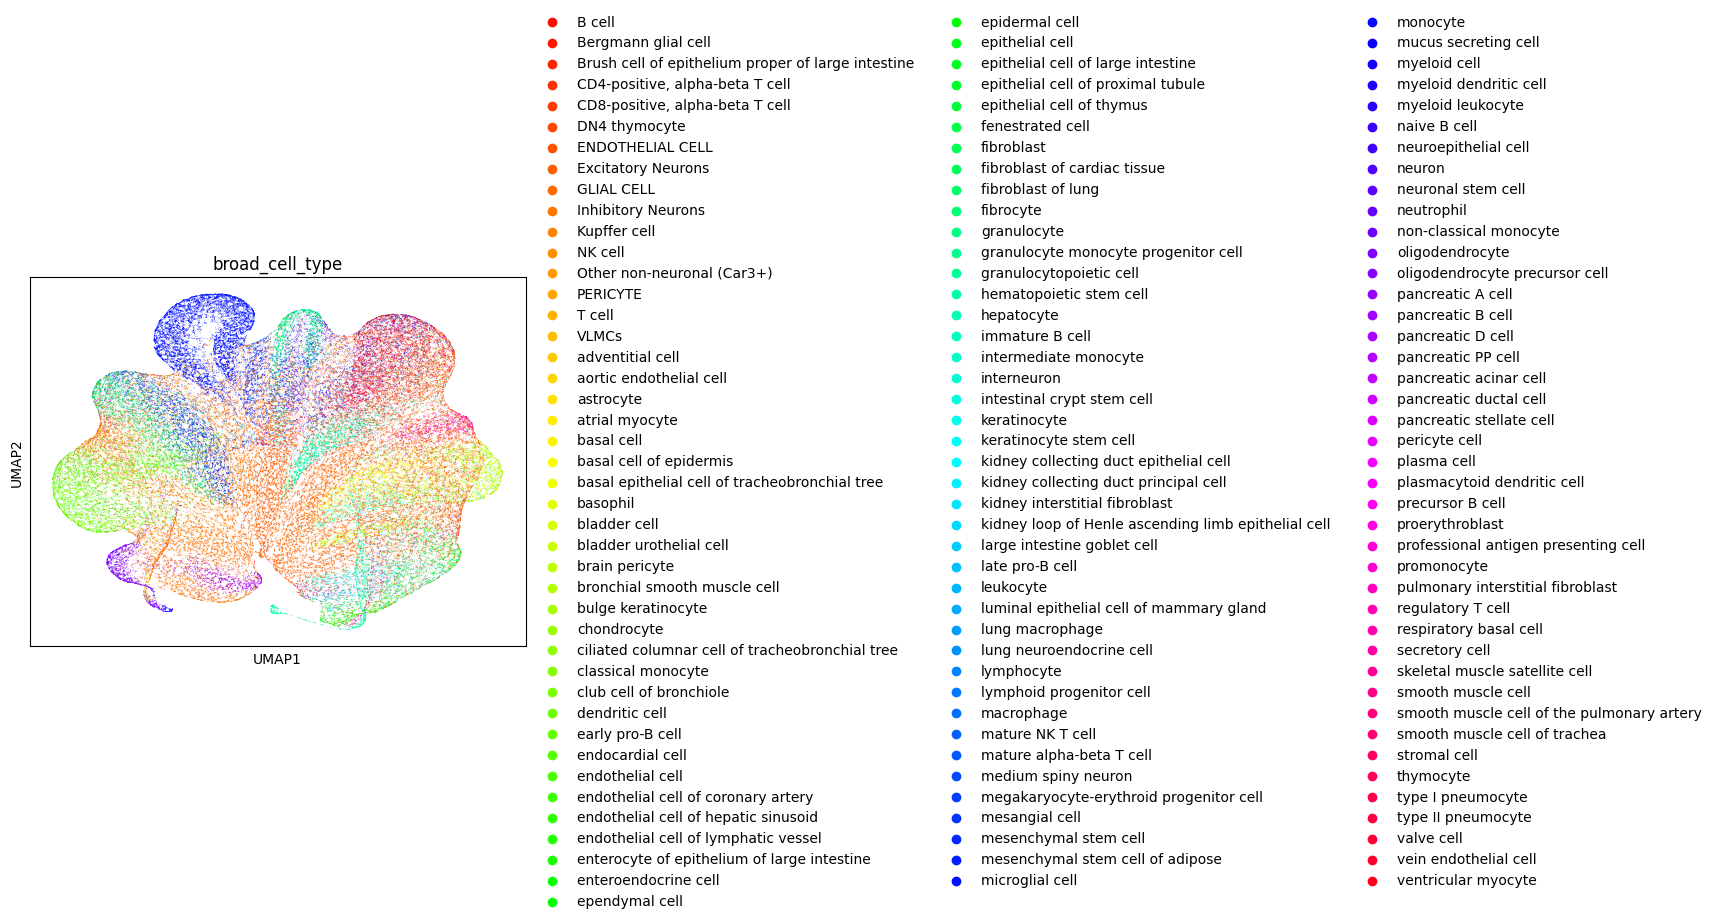

AttributeError: 'NoneType' object has no attribute 'figure'

In [29]:
import os 
import seaborn as sns
group = "broad_cell_type"
mdata["rna"].obs[group] = mdata["rna"].obs[group].astype("category")

categories = mdata["rna"].obs[group].cat.categories
num_categories = len(categories)

palette = sns.color_palette("hsv", num_categories)  # hsv is good for many distinct classes
color_map = dict(zip(categories, palette))

fig = sc.pl.umap(
    mdata["rna"],
    color=group,
    palette=color_map,
    show=True,
    legend_loc='right margin'  # You can also try 'right margin' if you want to show the legend
)

fig_path = os.path.join(
    "/gpfs/commons/home/svaidyanathan/repos/multivi_tools_splicing/figures", 
    "umap_broad_cell_type.png"
)
fig.figure.savefig(fig_path, dpi=300, bbox_inches="tight")
plt.close(fig.figure)

## 9. (Optional) Write Updated AnnData

Includes the new `.obsm["X_multivi"]` for further usage.

In [17]:
combined_adata.write(OPTIONAL_ANNDATA_MULTIVI_LATENT_SPACE_PATH)
print(f"Updated AnnData with latent space written to: {OPTIONAL_ANNDATA_MULTIVI_LATENT_SPACE_PATH}")

AnnData object with n_obs × n_vars = 19942 × 77042
    obs: 'batch_id', 'modality', 'mouse.id', '_indices', '_scvi_batch', '_scvi_labels', 'age', 'sex', 'cell_type_grouped', 'cell_ontology_class'
    var: 'ID', 'modality', 'n_cells'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'GE_X_umap'
    layers: 'cell_by_cluster_matrix', 'cell_by_junction_matrix'


## 10. Custom Plot Example

Manual plotting with matplotlib if you want custom styling or a side-by-side figure.

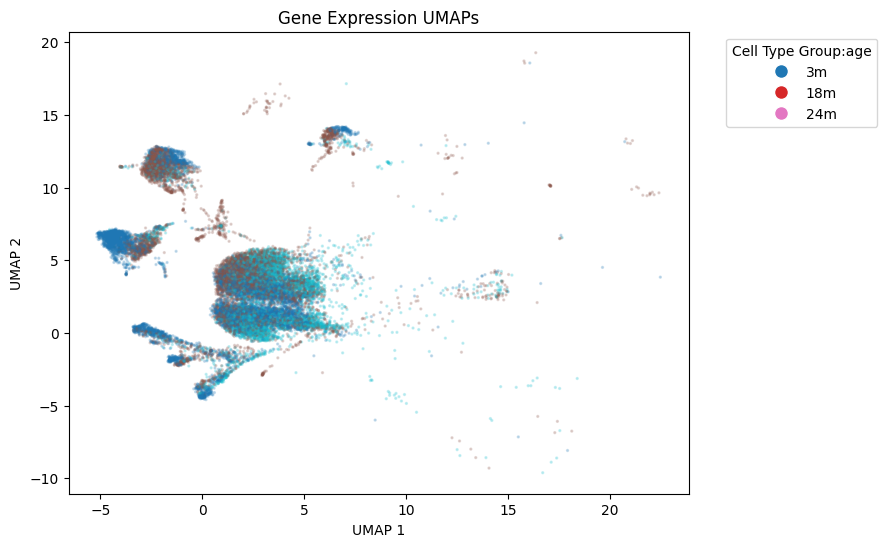

In [19]:
plt.figure(figsize=(8, 6))
group = "age"  # or any column in combined_adata.obs
if group in combined_adata.obs.columns:
    cell_types = combined_adata.obs[group].astype("category")
    umap_coords = combined_adata.obsm["X_umap"]

    scatter = plt.scatter(
        umap_coords[:, 0],
        umap_coords[:, 1],
        c=cell_types.cat.codes,
        cmap="tab10",
        alpha=0.2,
        s=2
    )
    legend_labels = cell_types.cat.categories
    legend_handles = [
        plt.Line2D(
            [0], [0],
            marker="o",
            color="w",
            markerfacecolor=plt.cm.tab10(i / len(legend_labels)),
            markersize=10
        )
        for i in range(len(legend_labels))
    ]
    plt.legend(
        legend_handles, legend_labels,
        title=f"UMAP colored by: {group}",
        bbox_to_anchor=(1.05, 1),
        loc="upper left"
    )

    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.title(f"UMAP (field: {group})")
    plt.show()
else:
    print(f"Column '{group}' not found in .obs.")